In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!pip install kaggle

In [3]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): MIT
 99% 557M/565M [00:07<00:00, 83.3MB/s]
100% 565M/565M [00:07<00:00, 79.8MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fashion-product-images-small.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import os

files = os.listdir('/content/images')
print('Total images:', len(files))


Total images: 44441


In [6]:
#Ye code images ke full file paths banane ke liye use kiya gaya hai, taaki baad me unhe display ya access kiya ja sake.
filenames =[]
for file in os.listdir('/content/images'):
  filenames.append(os.path.join('/content/images', file))

In [7]:
import numpy as np
import tensorflow as tf
import pickle as pkl
from numpy.linalg import norm
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.neighbors import NearestNeighbors

from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, GlobalMaxPooling2D

In [8]:
#Ye image se features nikalne ke liye pretrained ResNet50 model banata hai,
#jisse training nahi karni aur output ek fixed-length vector me convert karta hai.
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model.trainable = False
model = tf.keras.models.Sequential([model, GlobalMaxPooling2D()])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 2048)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
# Image ko resize, array me convert, batch dimension add, aur preprocess karta hai.
# Phir model se feature extract karke us feature ko normalize karta hai.
from tensorflow.keras.preprocessing import image

def extract_feature_from_image(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array)
    result = model.predict(img_preprocessed).flatten()
    norm_result = result / np.linalg.norm(result)
    return norm_result

In [11]:
extract_feature_from_image(filenames[0], model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


array([0.00759487, 0.0461197 , 0.00197496, ..., 0.02583733, 0.03799514,
       0.10102978], dtype=float32)

In [34]:
image_feature = []

for file in filenames[:1000]:   # 1000 images ke liye features extract karna
    feature = extract_feature_from_image(file, model)
    image_feature.append(feature)


    print(file)
    # print(feature)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
/content/images/24152.jpg
[0.01133813 0.05032103 0.00034257 ... 0.00709987 0.02407527 0.08774864]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
/content/images/24848.jpg
[0.00392699 0.01546061 0.         ... 0.00206527 0.03122619 0.05091545]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
/content/images/25263.jpg
[0.00010371 0.00687151 0.0008795  ... 0.00329297 0.00334433 0.02736241]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
/content/images/46547.jpg
[0.         0.00115966 0.00294268 ... 0.01955718 0.01850786 0.00072884]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
/content/images/37085.jpg
[0.         0.00414223 0.0122627  ... 0.0062312  0.03548814 0.00024237]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
/content/images/52416.jpg
[0.00590129 0.0401557  0.01155422 ... 0.00701458 0.01536953 0.00291049]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
/content/images/50765.jpg
[0.00053645 0.00377625 0.00759584 ... 0.0111769  0.02081644 0.        ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
/content/ima

In [35]:
image_feature = pkl.dump(image_feature, open('image_feature.pkl', 'wb'))
filenames = pkl.dump(filenames, open('filenames.pkl', 'wb'))

In [36]:
image_feature = pkl.load(open('image_feature.pkl', 'rb'))
filenames = pkl.load(open('filenames.pkl', 'rb'))

In [37]:
np.array(image_feature).shape

(1000, 2048)

In [60]:
neighbours = NearestNeighbors(n_neighbors=6, algorithm='auto', metric='euclidean')

In [61]:
neighbours.fit(image_feature)

NearestNeighbors(metric='euclidean', n_neighbors=6)

In [40]:
input_image = extract_feature_from_image("/content/1165.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [41]:
distence,indices = neighbours.kneighbors([input_image])

In [42]:
indices[0]

array([187, 692, 603, 541,  91, 386])

In [43]:
from IPython.display import Image

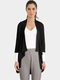

In [44]:
# Instantiate the Image class with the image path
display(Image('/content/1165.jpg'))

In [45]:
!pip install flask pyngrok


In [46]:
!pip install flask-ngrok pyngrok

In [47]:
!pip install streamlit

In [73]:
from google.colab import files

print("Upload 'image_feature.pkl' and 'filenames.pkl'")
uploaded = files.upload()


Upload 'image_feature.pkl' and 'filenames.pkl'


Saving image_feature.pkl to image_feature (1).pkl
Saving filenames.pkl to filenames (2).pkl


In [80]:
%%writefile /content/app.py
import streamlit as st
import pickle
import numpy as np
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.neighbors import NearestNeighbors

# Load model
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Load features and filenames
with open('/content/image_feature.pkl', 'rb') as f:
    image_features = pickle.load(f)[:1000]

with open('/content/filenames.pkl', 'rb') as f:
    filenames = pickle.load(f)[:1000]

image_features = np.array(image_features)
nbrs = NearestNeighbors(n_neighbors=6, algorithm='auto').fit(image_features)

# Feature extraction function
def extract_features(img):
    img = img.resize((224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature = model.predict(x).flatten()
    return feature / np.linalg.norm(feature)

# Streamlit UI
st.title("🔍 Image Recommendation App")
uploaded_file = st.file_uploader("Upload an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    img = Image.open(uploaded_file).convert('RGB')
    st.image(img, caption="Uploaded Image", use_container_width=True)

    query_feature = extract_features(img).reshape(1, -1)
    distances, indices = nbrs.kneighbors(query_feature)

    st.subheader("🔗 Top 5 Recommended Images:")
    cols = st.columns(5)
    for i, idx in enumerate(indices[0][1:6]):  # skip first (same image), show next 5
        with cols[i % 5]:
            st.image(filenames[idx], use_container_width=True)


Overwriting /content/app.py


In [81]:
# Kill any previous processes (optional)
!pkill streamlit
!pkill ngrok

# Set ngrok token (only once)
!ngrok config add-authtoken 2xFzrqv0DqljwNSEL7GTsiExZgz_6nqyZcnsa5agW9kCN5cBj

# Start Streamlit
get_ipython().system_raw('streamlit run /content/app.py &')

# Connect ngrok to Streamlit port
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print(f"🌐 Streamlit App is live at: {public_url}")


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
🌐 Streamlit App is live at: NgrokTunnel: "https://c44e-34-83-84-230.ngrok-free.app" -> "http://localhost:8501"
